In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from utils import (
    load_json,
    motif_data_to_json,
    balance_response_vector,
    overwrite_excel_sheet,
    download_motif_info,
    plot_hyperparameter_selection,
    tune_logistic_regression,
    tune_random_forest
)

In [2]:
root = os.getcwd() # gives path to git clone
data_dir = os.path.join(root, "Data")
fig_dir = os.path.join(root, "Figures")

filenames = {
    "identified motifs": "identified_motifs.json",
    "genes details": "logfc_rpkm_pr.csv",
    "Arabidopsis GO annotations": "tair.gaf.gz",
    "motif info": "motif_info.csv",
    "models output": "models_output.xlsx",
    "supplementary table": [
        "12864_2023_9714_MOESM2_ESM.xlsx",
        {
            "identified DEGs": "02. Epi DEGs (ctrls @ all tps)",
            "identified motifs": "03. Motifs Identified Using AME",
            "consistent TFs": "04. Consistent TFs"
        }
    ]
}

# Preprocessing Data

In [3]:
input_dir = os.path.join(data_dir, "motif_features.txt")
output_dir = os.path.join(data_dir, filenames["identified motifs"])

if not os.path.isfile(output_dir):
    motif_data_to_json(input_dir, output_dir)

In [7]:
file_dir = os.path.join(data_dir, filenames["genes details"])
df = pd.read_csv(file_dir)
df.set_index("Unnamed: 0", inplace=True, drop=True)
df.index.name = "AGI"

file_dir = os.path.join(data_dir, filenames["supplementary table"][0])
sheet_name = filenames["supplementary table"][1]["identified DEGs"]

degs = pd.read_excel(file_dir, sheet_name=sheet_name)
degs.set_index("AGI", inplace=True, drop=True)

df["DEG"] = 0
df["Cluster"] = -1

degs_list = sorted(list(set(degs.index).intersection(set(df.index))))

df.loc[degs_list, "DEG"] = 1
df.loc[degs_list, "Cluster"] = degs.loc[degs_list, "Cluster #"]

In [8]:
input_dir = os.path.join(data_dir, filenames["identified motifs"])
motifs = load_json(input_dir)

motifs_list = set()
for k in motifs.keys():
    motifs_list = motifs_list.union(set(motifs[k]))
motifs_list = sorted(list(motifs_list))

genes_list = sorted(list(set(motifs.keys()).intersection(set(df.index))))

print(f"{len(motifs_list)} motifs and {len(genes_list)} AGIs found at the end.")

371 motifs and 5240 AGIs found at the end.


In [9]:
motifs_info = download_motif_info(motifs_list)

motifs_info.set_index("Motif Description", inplace=True, drop=True)
motifs_info["AGI"] = motifs_info["AGI"].astype(str)
motifs_info["AGI"] = motifs_info["AGI"].replace(r'(\r\n|\n|\r)', ' ', regex=True)

file_dir = os.path.join(data_dir, filenames["supplementary table"][0])
sheet_name = filenames["supplementary table"][1]["identified motifs"]

motifs_info_paper = pd.read_excel(file_dir, sheet_name=sheet_name)
motifs_info_paper.dropna(subset=["Motif Description"], inplace=True)
motifs_info_paper.set_index("Motif Description",inplace=True, drop=True)

commons = set(motifs_info.index).intersection(set(motifs_info_paper.index))
commons = sorted(list(commons))

a = motifs_info.loc[commons, "AGI"]
b = motifs_info_paper.loc[commons, "AGI"]
motifs_info["AGI"] = motifs_info["AGI"].where(a == b, b)
motifs_info.reset_index(inplace=True, drop=False)

# Save or preview
output_dir = os.path.join(data_dir, filenames["motif info"])
# motifs_info.dropna(subset=["AGI"], inplace=True)
motifs_info.to_csv(output_dir, index=False)
motifs_info

,Motif Description,AGI,GeneSymbol,Description
0,ABI3VP1_tnt.AT5G18090_col_a_m1,AT5G18090,None,AP2/B3-like transcriptional factor family prot...
1,ABI3VP1_tnt.AT5G60130_col_a_m1,AT5G60130,None,AP2/B3-like transcriptional factor family prot...
2,ABI3VP1_tnt.FUS3_col_a_m1,AT3G26790,FUS3,AP2/B3-like transcriptional factor family prot...
3,ABI3VP1_tnt.REM16_col_a_m1,AT4G33280,REM16,None
4,ABI3VP1_tnt.VRN1_col_a_m1,AT3G18990,VRN1,AP2/B3-like transcriptional factor family prot...
...,...,...,...,...
366,bZIP_tnt.bZIP50_col_v31_m1,NaN,BZIP50,None
367,bZIP_tnt.bZIP53_col_m1,AT3G62420,BZIP53,basic region/leucine zipper motif 53 [Source:N...
368,bZIP_tnt.bZIP68_col_a_m1,AT1G32150,BZIP68,None
369,mTERF_tnt.AT5G23930_col_a_m1,AT5G23930,None,Mitochondrial transcription termination factor...


In [10]:
X = pd.DataFrame(index=genes_list, columns=motifs_list, data=0)
for k in motifs.keys():
    cols_set = set(motifs_list).intersection(set(motifs[k]))
    X.loc[k, sorted(list(cols_set))] = 1
X

,ABI3VP1_tnt.AT5G18090_col_a_m1,ABI3VP1_tnt.AT5G60130_col_a_m1,ABI3VP1_tnt.FUS3_col_a_m1,ABI3VP1_tnt.REM16_col_a_m1,ABI3VP1_tnt.VRN1_col_a_m1,AP2EREBP_tnt.ABR1_col_a_m1,AP2EREBP_tnt.AT1G01250_col_a_m1,AP2EREBP_tnt.AT1G12630_col_a_m1,AP2EREBP_tnt.AT1G28160_col_a_m1,AP2EREBP_tnt.AT1G44830_col_a_m1,...,bZIP_tnt.bZIP3_col_a_m1,bZIP_tnt.bZIP42_col_a_m1,bZIP_tnt.bZIP43_col_a_m1,bZIP_tnt.bZIP44_col_m1,bZIP_tnt.bZIP48_col_a_m1,bZIP_tnt.bZIP50_col_v31_m1,bZIP_tnt.bZIP53_col_m1,bZIP_tnt.bZIP68_col_a_m1,mTERF_tnt.AT5G23930_col_a_m1,zfGRF_tnt.AT3G42860_col_a_m1
AT1G01140,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
AT1G01180,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
AT1G01210,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AT1G01260,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG00950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ATMG01210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ATMG01290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ATMG01340,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def form_output(objective, genes_list, params=None):
    if params is None:
        params = {}

    y = pd.Series(index=genes_list)
    if objective == "DEG":
        y = df.loc[genes_list, "DEG"]
    elif objective == "Cluster":
        cluster = params["cluster"]
        y = df.loc[genes_list, "Cluster"].apply(lambda x: 1 if x == cluster else 0)
    elif objective == "DE":
        time_cols = [chr(ord('A') + i//6) for i in range(6, 42, 6)]
        y = df.loc[genes_list, time_cols]
        y = y.max(axis=1)

    return y

y = form_output("DEG", genes_list, {"cluster": 1})
y = balance_response_vector(y, abs_boundary=0.75, prop=1.0)
y

AGI
AT1G01140    1
AT1G01180    1
AT1G01210    1
AT1G01260    0
AT1G01300    0
            ..
ATMG00930    0
ATMG00950    0
ATMG01210    0
ATMG01290    0
ATMG01340    0
Name: DEG, Length: 5012, dtype: int64

In [12]:
relevant_genes = set(y.index).intersection(set(X.index))
relevant_genes = list(relevant_genes)
np.random.shuffle(relevant_genes)
X_ = X.loc[relevant_genes]
y_ = y[relevant_genes]
X_

,ABI3VP1_tnt.AT5G18090_col_a_m1,ABI3VP1_tnt.AT5G60130_col_a_m1,ABI3VP1_tnt.FUS3_col_a_m1,ABI3VP1_tnt.REM16_col_a_m1,ABI3VP1_tnt.VRN1_col_a_m1,AP2EREBP_tnt.ABR1_col_a_m1,AP2EREBP_tnt.AT1G01250_col_a_m1,AP2EREBP_tnt.AT1G12630_col_a_m1,AP2EREBP_tnt.AT1G28160_col_a_m1,AP2EREBP_tnt.AT1G44830_col_a_m1,...,bZIP_tnt.bZIP3_col_a_m1,bZIP_tnt.bZIP42_col_a_m1,bZIP_tnt.bZIP43_col_a_m1,bZIP_tnt.bZIP44_col_m1,bZIP_tnt.bZIP48_col_a_m1,bZIP_tnt.bZIP50_col_v31_m1,bZIP_tnt.bZIP53_col_m1,bZIP_tnt.bZIP68_col_a_m1,mTERF_tnt.AT5G23930_col_a_m1,zfGRF_tnt.AT3G42860_col_a_m1
AT5G37280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT3G51290,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G26700,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G59950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT3G06850,0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G49950,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AT2G16145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AT2G39330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G64420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# X_.sum().hist(bins=100, density=True)
# X_.sum().sum() / (X_.shape[0] * X_.shape[1])
y_.sum()/len(y_)

np.float64(0.5)

In [13]:
def enrich_candidate_motifs(tmp):

    tmp["AGI"] = motifs_info.set_index("Motif Description").loc[tmp.index, "AGI"]
    tmp["Description"] = motifs_info.set_index("Motif Description").loc[tmp.index, "Description"]
    tmp["Gene Symbol"] = motifs_info.set_index("Motif Description").loc[tmp.index, "GeneSymbol"]

    tmp.index.name = "Motif Description"
    tmp.reset_index(drop=False, inplace=True)
    tmp.sort_values("AGI", inplace=True)
    tmp.reset_index(drop=True, inplace=True)

    tmp["DEG"] = None
    time_cols = [chr(ord('A') + i//6) for i in range(6, 42, 6)]
    tmp[time_cols] = None
    tmp["Max DE"] = None
    tmp["Min DE"] = None
    for i in tmp.index:
        agi = tmp.loc[i, "AGI"]
        if agi in df.index:
            tmp.at[i, "DEG"] = df.loc[agi, "DEG"]
            tmp.at[i, "Max DE"] = df.loc[agi, time_cols].max()
            tmp.at[i, "Min DE"] = df.loc[agi, time_cols].min()
            tmp.loc[i, time_cols] = df.loc[agi, time_cols]
    return tmp

def build_result(tmp, score, method):
    result = {
        "recognized motifs": enrich_candidate_motifs(tmp),
        "score": score,
        "method": method
    }

    file_dir = os.path.join(data_dir, filenames["supplementary table"][0])
    sheet_name = filenames["supplementary table"][1]["consistent TFs"]
    TFs = pd.read_excel(file_dir, sheet_name=sheet_name)
    TFs.dropna(subset=["AGI"], inplace=True)
    result["recognized motifs"]["Found in Reference"] = (
        result["recognized motifs"]["AGI"].isin(TFs["AGI"]).astype(int))

    output_dir = os.path.join(data_dir, filenames["models output"])
    overwrite_excel_sheet(output_dir, f"{result["method"]} ({result["score"]:0.2f})", result["recognized motifs"])

# Logistic Regression with LASSO

In [14]:
accepting_criterion = 'first in 0.01 margin'
k = 10
lasso_selected_ind, lasso_c_values, lasso_scores = tune_logistic_regression(
    X_, y_, np.logspace(-3, 1.2, 101),
    k, accepting_criterion, 'l1', random_state=2025)

print("Best C:", lasso_c_values[lasso_selected_ind])
print("Test Accuracy:", lasso_scores[lasso_selected_ind])

Best C: 0.36475394692560803
Test Accuracy: 0.9273727445507391


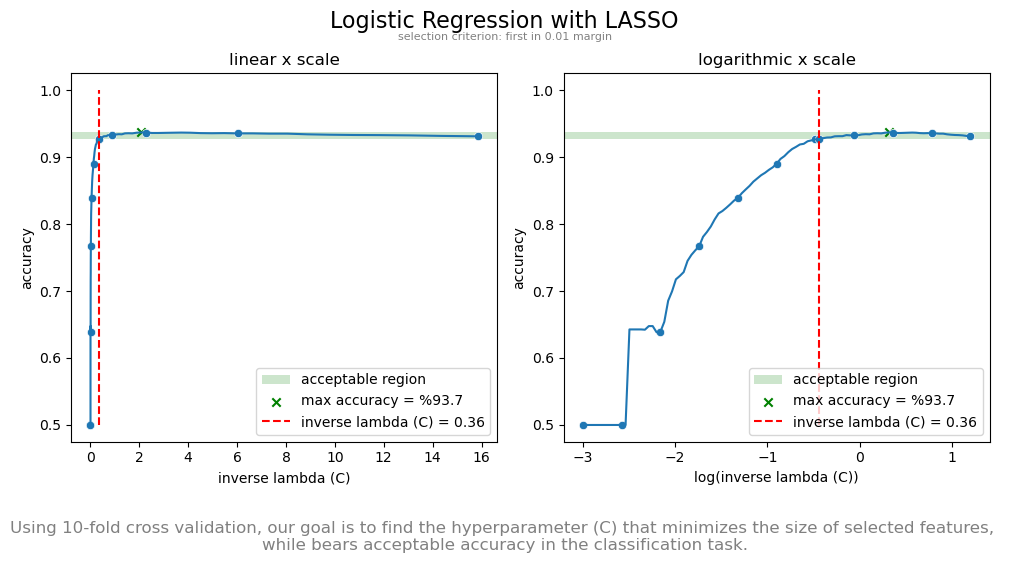

In [15]:
headline = f'Logistic Regression with LASSO'
caption = f"Using {k}-fold cross validation, our goal is to find the hyperparameter (C) that minimizes the size of selected features, \nwhile bears acceptable accuracy in the classification task."

plot_hyperparameter_selection(
    lasso_c_values,
    lasso_scores,
    accepting_criterion,
    lasso_selected_ind,
    'inverse lambda (C)',
    caption=caption,
    headline=headline)

In [16]:
# Set the number of experiment repetitions (k)
k = 20

coefficients = []
scores = []
for _ in range(k):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=_)
    model = LogisticRegression(
        penalty='l1', solver='liblinear',
        max_iter=1000, random_state=_,
        C=lasso_c_values[lasso_selected_ind])
    clf = model.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    coefficients.append(model.coef_.flatten())

tmp_lasso = pd.DataFrame(index=range(k), columns=X_.columns, data=coefficients)
nonzero_cols = np.all(tmp_lasso.to_numpy() != 0, axis=0)
tmp_lasso = tmp_lasso.iloc[:, nonzero_cols]
tmp_lasso = pd.DataFrame(data=tmp_lasso.mean(axis=0), columns=["LR LASSO coefficient"])

build_result(tmp_lasso, np.average(scores), "LR with LASSO")
tmp_lasso

,Motif Description,LR LASSO coefficient,AGI,Description,Gene Symbol,DEG,B,C,D,E,F,G,Max DE,Min DE,Found in Reference
0,AP2EREBP_tnt.ERF10_col_a_m1,-0.464451,AT1G03800,ERF domain protein 10 [Source:NCBI gene (forme...,ERF10,0,-1.840705,-1.115951,-0.198703,-0.463696,-0.096932,-0.976042,-0.096932,-1.840705,0
1,C2H2_tnt.MGP_col_a_m1,2.238017,AT1G03840,C2H2 and C2HC zinc fingers superfamily protein...,MGP,0,0.181324,-2.389563,-0.187825,2.401043,-0.212274,-0.296004,2.401043,-2.389563,0
2,ARID_tnt.AT1G04880_col_a_m1,-1.364112,AT1G04880,HMG (high mobility group) box protein with ARI...,None,0,-0.739298,0.441243,0.864851,0.565333,0.445535,0.0,0.864851,-0.739298,0
3,LOBAS2_tnt.LBD2_col_a_m1,0.330149,AT1G06280,LOB domain-containing protein 2 [Source:NCBI g...,LBD2,0,0.0,16.687873,1.870831,1.170932,-0.939344,-14.942253,16.687873,-14.942253,0
4,MYB_tnt.MYB61_col_a_m1,-1.281441,AT1G09540,myb domain protein 61 [Source:NCBI gene (forme...,MYB61,0,-0.892021,0.478923,0.407008,0.160218,0.186941,0.019766,0.478923,-0.892021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,HB_tnt.PHV_col_a_m1,-2.382768,NaN,Homeobox-leucine zipper family protein / lipid...,PHV,None,None,None,None,None,None,None,None,None,0
125,MYB_tnt.MYB58_col_a_m1,-0.821873,NaN,myb domain protein 58 [Source:NCBI gene (forme...,MYB58,None,None,None,None,None,None,None,None,None,0
126,MYB_tnt.MYB70_col_a_m1,-3.969251,NaN,myb domain protein 70 [Source:NCBI gene (forme...,MYB70,None,None,None,None,None,None,None,None,None,0
127,RAV_tnt.RAV1_col_m1,-2.171461,NaN,uncharacterized protein [Source:NCBI gene (for...,RAV1,None,None,None,None,None,None,None,None,None,0


In [48]:
tmp_lasso["Total"] = 1
tmp_lasso["non-DEG"] = 1 - tmp_lasso["DEG"]
tmp_lasso["non-DEG and Found in Reference"] = tmp_lasso[["non-DEG", "Found in Reference"]].all(axis=1)
tmp_lasso[["DEG", "non-DEG", "Total", "Found in Reference", "non-DEG and Found in Reference"]].sum(axis=0)

DEG                                18
non-DEG                           103
Total                             129
Found in Reference                  8
non-DEG and Found in Reference      8
dtype: object

# Elastic Net Logistic Regression

Why: It's a generalization of LASSO that combines L1 and L2 penalties. It stabilizes selection when features are correlated.

Interpretability: Still yields sparse solutions, but less aggressive than pure LASSO.

Use LogisticRegressionCV in sklearn with penalty='elasticnet' and solver='saga'.

In [20]:
accepting_criterion = 'first in 0.01 margin'
k = 10

l1_ratios = [0.5] # [0.2, 0.5, 0.8]
elasticnet_best_model = {
    "selected_ind": 0,
    "max accuracy" : 0,
    "c_values": None,
    "scores": None,
    "l1_ratio": 0
}
for l1_ratio in l1_ratios:
    elasticnet_selected_ind, elasticnet_c_values, elasticnet_scores = tune_logistic_regression(
        X_, y_, np.logspace(-3, 1, 41),
        k, accepting_criterion,
        'elasticnet', l1_ratio, random_state=2025)
    if elasticnet_best_model["max accuracy"] < np.max(elasticnet_scores):
        elasticnet_best_model["max accuracy"] = np.max(elasticnet_scores)
        elasticnet_best_model["selected_ind"] = elasticnet_selected_ind
        elasticnet_best_model["c_values"] = elasticnet_c_values
        elasticnet_best_model["scores"] = elasticnet_scores
        elasticnet_best_model["l1_ratio"] = l1_ratio

print("Best C:", elasticnet_best_model["c_values"][elasticnet_best_model["selected_ind"]])
print("Best l1_ratio:", elasticnet_best_model["l1_ratio"])
print("Test Accuracy:", elasticnet_best_model["scores"][elasticnet_best_model["selected_ind"]])

0.5
Best C: 0.3981071705534973
Best l1_ratio: 0.5
Test Accuracy: 0.9273727445507391


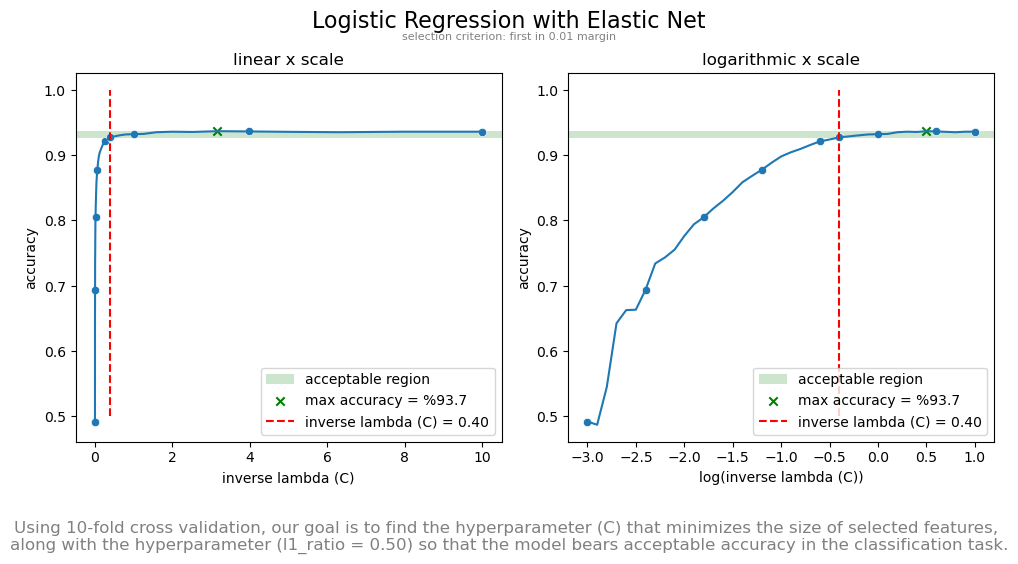

In [21]:
headline = f'Logistic Regression with Elastic Net'
caption = f"Using {k}-fold cross validation, our goal is to find the hyperparameter (C) that minimizes the size of selected features, \nalong with the hyperparameter (l1_ratio = {elasticnet_best_model["l1_ratio"]:0.2f}) so that the model bears acceptable accuracy in the classification task."

plot_hyperparameter_selection(
    elasticnet_best_model["c_values"],
    elasticnet_best_model["scores"],
    accepting_criterion,
    elasticnet_best_model["selected_ind"],
    'inverse lambda (C)',
    caption=caption,
    headline=headline)

In [22]:
# Set the number of experiment repetitions (k)
k = 20

coefficients = []
scores = []
for _ in range(k):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=_)
    model = LogisticRegression(
        penalty='elasticnet', solver='saga',
        max_iter=10000, random_state=_, l1_ratio=elasticnet_best_model["l1_ratio"],
        C=elasticnet_best_model["c_values"][elasticnet_best_model["selected_ind"]])
    clf = model.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    coefficients.append(model.coef_.flatten())

tmp_elasticnet = pd.DataFrame(index=range(k), columns=X_.columns, data=coefficients)
nonzero_cols = np.all(tmp_elasticnet.to_numpy() != 0, axis=0)
tmp_elasticnet = tmp_elasticnet.iloc[:, nonzero_cols]
tmp_elasticnet = pd.DataFrame(data=tmp_elasticnet.mean(axis=0), columns=["LR EN coefficient"])

build_result(tmp_elasticnet, np.average(scores), "LR with Elastic Net")
tmp_elasticnet

,Motif Description,LR EN coefficient,AGI,Description,Gene Symbol,DEG,B,C,D,E,F,G,Max DE,Min DE,Found in Reference
0,AP2EREBP_tnt.AT1G01250_col_a_m1,0.398324,AT1G01250,Integrase-type DNA-binding superfamily protein...,None,0,15.620864,0.0,0.0,0.0,-13.358975,0.0,15.620864,-13.358975,0
1,NAC_tnt.ATAF1_col_a_m1,0.765448,AT1G01720,NAC (No Apical Meristem) domain transcriptiona...,ATAF1,1,-0.361675,-0.204334,-0.048739,-0.704398,-0.435285,0.157947,0.157947,-0.704398,0
2,NAC_tnt.ANAC005_col_a_m1,-0.187120,AT1G02250,None,ANAC005,0,-0.025261,-1.835745,-0.565002,-0.76062,-0.889288,-0.796309,-0.025261,-1.835745,0
3,AP2EREBP_tnt.ERF10_col_a_m1,-0.498012,AT1G03800,ERF domain protein 10 [Source:NCBI gene (forme...,ERF10,0,-1.840705,-1.115951,-0.198703,-0.463696,-0.096932,-0.976042,-0.096932,-1.840705,0
4,C2H2_tnt.MGP_col_a_m1,1.420776,AT1G03840,C2H2 and C2HC zinc fingers superfamily protein...,MGP,0,0.181324,-2.389563,-0.187825,2.401043,-0.212274,-0.296004,2.401043,-2.389563,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,MYB_tnt.MYB44_col_m1,0.755975,NaN,None,MYB44,None,None,None,None,None,None,None,None,None,0
194,MYB_tnt.MYB58_col_a_m1,-0.980790,NaN,myb domain protein 58 [Source:NCBI gene (forme...,MYB58,None,None,None,None,None,None,None,None,None,0
195,MYB_tnt.MYB70_col_a_m1,-2.504310,NaN,myb domain protein 70 [Source:NCBI gene (forme...,MYB70,None,None,None,None,None,None,None,None,None,0
196,RAV_tnt.RAV1_col_m1,-1.692611,NaN,uncharacterized protein [Source:NCBI gene (for...,RAV1,None,None,None,None,None,None,None,None,None,0


In [49]:
tmp_elasticnet["Total"] = 1
tmp_elasticnet["non-DEG"] = 1 - tmp_elasticnet["DEG"]
tmp_elasticnet["non-DEG and Found in Reference"] = tmp_elasticnet[["non-DEG", "Found in Reference"]].all(axis=1)
tmp_elasticnet[["DEG", "non-DEG", "Total", "Found in Reference", "non-DEG and Found in Reference"]].sum(axis=0)

DEG                                24
non-DEG                           160
Total                             198
Found in Reference                 15
non-DEG and Found in Reference     14
dtype: object

# Random Forest with Feature Importance Thresholding

Why: Not inherently sparse, but you can extract top features via impurity or permutation importance.

Interpretability: Use feature importance to preselect features for downstream modeling.

Use: RandomForestClassifier, then rank features.

In [17]:
accepting_criterion = 'first in 0.01 margin'
k = 10

rf_selected_ind, rf_n_features, rf_scores, best_rf, sufficient_features = tune_random_forest(
    X_, y_, k, accepting_criterion,
    n_estimators=[10, 50, 100, 150, 200],
    max_depths=[None, 10, 20],
    random_state=2025)

print("Best No. of Features:", rf_n_features[rf_selected_ind])
print("Test Accuracy:", rf_scores[rf_selected_ind])

Baseline accuracy (all 371 features): 0.9890
Best tuned RF accuracy: 0.9836
Best params: {'max_depth': None, 'n_estimators': 100}
Best No. of Features: 51
Test Accuracy: 0.9836394939205254


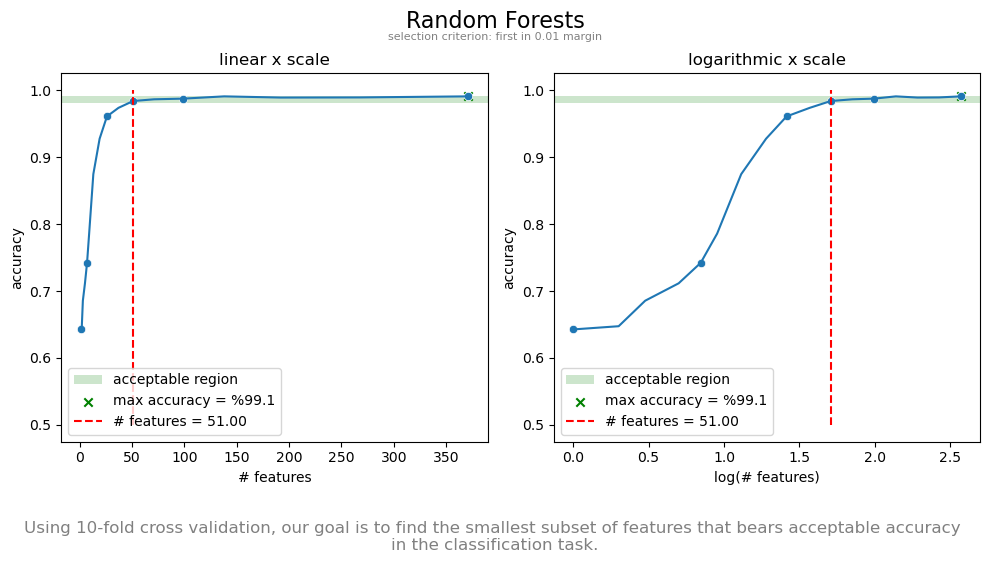

In [18]:
headline = f'Random Forests'
caption = f"Using {k}-fold cross validation, our goal is to find the smallest subset of features that bears acceptable accuracy \nin the classification task."

plot_hyperparameter_selection(
    rf_n_features, rf_scores, accepting_criterion, rf_selected_ind, '# features',
    caption=caption, headline=headline)

In [19]:
tmp_rf = pd.DataFrame(
    index=sufficient_features,
    columns=["RF feature importance"],
    data=best_rf.feature_importances_)

build_result(tmp_rf, rf_scores[rf_selected_ind], "Random Forests")
tmp_rf

,Motif Description,RF feature importance,AGI,Description,Gene Symbol,DEG,B,C,D,E,F,G,Max DE,Min DE,Found in Reference
0,C2H2_tnt.MGP_col_a_m1,0.014108,AT1G03840,C2H2 and C2HC zinc fingers superfamily protein...,MGP,0,0.181324,-2.389563,-0.187825,2.401043,-0.212274,-0.296004,2.401043,-2.389563,0
1,MYBrelated_tnt.AT1G18960_col_a_m1,0.021829,AT1G18960,myb-like HTH transcriptional regulator family ...,None,0,0.109109,0.162577,0.387154,0.025134,-0.406811,-1.029746,0.387154,-1.029746,0
2,AP2EREBP_tnt.At1g19210_col_a_m1,0.029291,AT1G19210,Integrase-type DNA-binding superfamily protein...,None,0,-0.173183,0.036541,0.149496,-0.314086,0.189374,0.344356,0.344356,-0.314086,0
3,Orphan_tnt.AT1G24250_col_a_m1,0.012230,AT1G24250,Paired amphipathic helix (PAH2) superfamily pr...,None,0,-0.122517,0.441255,2.26954,0.952466,-0.911476,1.184203,2.26954,-0.911476,0
4,C2C2dof_tnt.COG1_col_a_m1,0.019030,AT1G29160,None,COG1,1,-0.907533,-0.15288,0.028451,-0.925538,-0.33769,0.224177,0.224177,-0.925538,0
5,WRKY_tnt.WRKY71_col_a_m1,0.015806,AT1G29860,WRKY DNA-binding protein 71 [Source:NCBI gene ...,WRKY71,0,16.62119,-16.416121,0.653881,-16.372323,-0.271382,-2.780524,16.62119,-16.416121,0
6,MYB_tnt.MYB93_col_a_m1,0.018893,AT1G34670,myb domain protein 93 [Source:NCBI gene (forme...,MYB93,0,0.0,14.702726,0.0,0.0,0.0,0.0,14.702726,0.0,0
7,C2C2dof_tnt.Adof1_col_a_m1,0.012507,AT1G51700,None,ADOF1,0,-0.268372,0.436419,0.026722,0.174009,0.473762,-0.091506,0.473762,-0.268372,0
8,C2C2dof_tnt.At1g64620_100ng20cy_b_m1,0.022084,AT1G64620,Dof-type zinc finger DNA-binding family protei...,None,0,-14.916814,0.0,-0.426469,0.364344,-16.279649,-0.567836,0.364344,-16.279649,0
9,NAC_tnt.ANAC028_col_a_m1,0.023254,AT1G65910,None,ANAC028,0,0.172149,0.0,0.0,0.0,-12.52311,0.0,0.172149,-12.52311,0


In [50]:
tmp_rf["Total"] = 1
tmp_rf["non-DEG"] = 1 - tmp_rf["DEG"]
tmp_rf["non-DEG and Found in Reference"] = tmp_rf[["non-DEG", "Found in Reference"]].all(axis=1)
tmp_rf[["DEG", "non-DEG", "Total", "Found in Reference", "non-DEG and Found in Reference"]].sum(axis=0)

DEG                                3
non-DEG                           48
Total                             51
Found in Reference                 4
non-DEG and Found in Reference     4
dtype: object

In [65]:
print(f"LASSO: {len(set(tmp_lasso["AGI"]))}")
print(f"EN: {len(set(tmp_elasticnet["AGI"]))}")
print(f"RF: {len(set(tmp_rf["AGI"]))}")
print(f"LASSO+EN: {len(set(tmp_lasso["AGI"]).intersection(set(tmp_elasticnet["AGI"])))}")
print(f"LASSO+RF: {len(set(tmp_rf["AGI"]).intersection(set(tmp_lasso["AGI"])))}")
print(f"EN+RF: {len(set(tmp_rf["AGI"]).intersection(set(tmp_elasticnet["AGI"])))}")
len(set(tmp_elasticnet["AGI"]).intersection(set(tmp_rf["AGI"]).intersection(tmp_lasso["AGI"])))

LASSO: 122
EN: 185
RF: 51
LASSO+EN: 122
LASSO+RF: 39
EN+RF: 42


39

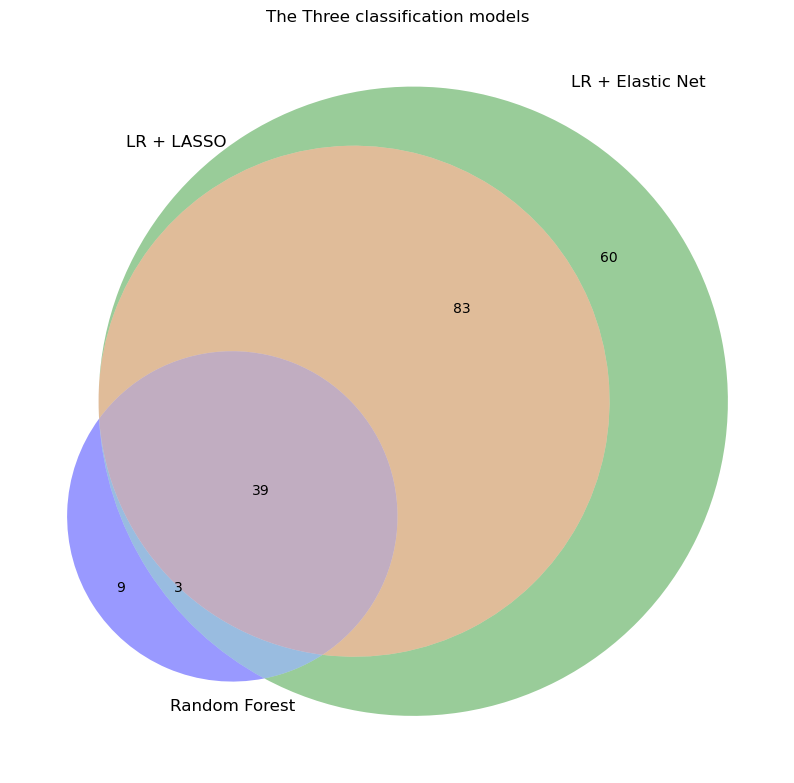

In [71]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.patheffects as path_effects

fig, ax = plt.subplots(figsize=(10, 10))
v = venn3(subsets=(set(tmp_lasso["AGI"]), set(tmp_elasticnet["AGI"]), set(tmp_rf["AGI"])), set_labels = ('LR + LASSO', 'LR + Elastic Net', 'Random Forest'), ax=ax)
# v.get_label_by_id('100').set_text(f'LR + LASSO ({baa})')
# v.get_label_by_id('010').set_text(f'LR + Elastic Net ({len(set(tmp_elasticnet["AGI"]))})')
# v.get_label_by_id('001').set_text(f'Random Forest ({len(set(tmp_rf["AGI"]))})')
# v.get_label_by_id('110').set_text(str(len(set(tmp_lasso["AGI"]).intersection(set(tmp_elasticnet["AGI"])))))
# v.get_label_by_id('011').set_text(str(len(set(tmp_rf["AGI"]).intersection(set(tmp_elasticnet["AGI"])))))
# v.get_label_by_id('101').set_text(str(len(set(tmp_rf["AGI"]).intersection(set(tmp_lasso["AGI"])))))
# v.get_label_by_id('111').set_text(str(len(set(tmp_elasticnet["AGI"]).intersection(set(tmp_rf["AGI"]).intersection(tmp_lasso["AGI"])))))
plt.title("The Three classification models")

# example_text = ('Example 1: The Vice President is considered "President of the Senate" and can vote to break ties.\n'
#                 'Example 2: The Legislature confirms Supreme Court justices.\n'
#                 'Example 3: The Executive appoints potential Supreme Court justices.')
#
# text = fig.text(0.0, 0.05, example_text, ha='left', va='bottom', size=14)
# text.set_path_effects([path_effects.Normal()])

plt.show()

# Stability Selection with Logistic Regression (LASSO)

Why: Combines bootstrapping with LASSO to reduce instability in variable selection.

Interpretability: Highlights consistently selected features across subsamples.

Use: sklearn.linear_model.LogisticRegressionCV with RandomizedLasso-style wrappers (via sklearn or stabl library).

# Bayesian Logistic Regression with Sparse Priors

Why: Methods like the Horseshoe prior yield sparsity with uncertainty quantification.

Interpretability: High, but more complex to implement.

Tools: PyMC, Stan, or pyro.

# Comparison of results

In [ ]:
# Re-import necessary libraries after environment reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(2025)

# Correlated data
x1 = np.linspace(-2, 2, 1000)
y1 = 2 * x1 - 0.01 * x1**2 + np.random.normal(0, 1.0, 1000)

# Uncorrelated but dependent (e.g., y = x^2)
x2 = np.linspace(-2, 2, 1000)
y2 = x2**2 - 0.3 * x2**3 + np.random.normal(0, 1, 1000)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Correlated plot
sns.scatterplot(x=x1, y=y1, ax=axes[0], color="dodgerblue")
axes[0].set_title("Correlation (DEG TF)")
axes[0].set_xlabel("Differential Expression in TF")
axes[0].set_ylabel("DE in Gene")

# Uncorrelated but dependent plot
sns.scatterplot(x=x2, y=y2, ax=axes[1], color="orange")
axes[1].set_title("Non-linear Dependence (non-DEG TF)")
axes[1].set_xlabel("Differential Expression in TF")

# Save the figure
plot_path = "correlation_vs_dependence.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plot_path
